# Competing for Talent: Is Competition in Hiring Linked to Higher Startup Employee Wages? Does Funding, Startup Status, Employee Experience Level, or The Total Number of Employees Hired Play a Role?

# PROJECT ONE:

## INTRODUCTION

The study of startups is a compelling research area for those concerned with innovation and markets. Startups have great potential to introduce novel technologies, but proper strategy is critical to achieving the brand recognition and reputation necessary for these impacts (Hashai & Markovich, 2017). Moreover, the positive effects aren’t limited to technology development. Startups can also be a source of attractive jobs by offering interesting positions or a close-knit work environment. The data surrounding startup pay suggests lower wages in general, but without a clear consensus. First, based on Danish registry data, Sorenson et al. concludes that startup employees earn about 17% less than employees at larger comparable firms over 10 years (Sorenson et al., 2021). Estimates from Germany also support lower salaries when everything else is held constant (Brixy et al., 2006). However, J. Daniel Kim’s work actually finds a wage premium for venture capital backed firms due to their selection of especially skillful employees (Kim, 2018).

Further, a study on MIT graduates finds no wage differences between startups and established companies when holding worker ability and skills constant (Kim, 2016). This provides even more evidence that any estimated startup wage premium is due to a selection effect alone. Although this analysis may not be externally valid for workers of lower ability, it emphasizes the importance of measures of employee experience and skill in any investigation of wage variation. Importantly, another critical wage determination factor is location. Regression findings from the Journal of Urban Economics indicate a roughly 19% wage premium for workers in general who live in urban areas (Yankow, 2006). This result is consistent with findings from Norway that specifically cite a higher concentration of college-educated people in cities as one reason behind this deviation (Carlsen et al., 2016).

Now, in regards to wage determination within startups in particular, Li Yang’s research on market competition and employee wage for Chinese companies found a statistically significant positive effect when competition rises (Yang, 2016). This work is relatively unique in studying wage determination for all employees rather than founders and it isolates the impact of competition itself on wages. As a result, it directly motivates my own analysis of hiring competition. 

In this paper, I examine the relationship between an estimator for startup hiring-related competition and wages by merging startup data from 2013 with technology sector salary data from 2016. Although I detect a very small effect of competition by itself, I explore differences in incentives for high pay at acquired startups (related to hiring strategy and employee experience level) and analyze regional wage, hiring competition, and tech conference prevalence differences in the US. Additionally, I find evidence of potential differential returns to experience for startups of different status through OLS regression, and observe increasing returns to having more than 8.5 years of experience for firms facing more hiring competition using regression trees.

## DATA EXPLANATION

I use individual level salary survey responses from Hacker News, combined with entity level startup investment data from Crunchbase. Observations are merged on company name, so startups are grouped with corresponding 2016 salaries of their employees.

The main outcome variable is annual base pay in USD from the salary survey responses.

### Explanatory variables:

*Total startup funding* (USD) is examined since it can act as a potential measure of the ability of a startup to pay high salaries. Comparing the impact of the number of competitor employees only for startups with similar funding can better isolate the effect.

Similarly, the *number of funding rounds* indicates the level of funding available, but also reveals how established the startup is. A later stage startup is likely to have received more funding rounds since it has proven some level of reputation and success to investors. As a result, it is another critical control variable.

A more explicit measure of how established a startup is its official status. *Startup status* is a a categorical variable with 7 unique values: acquired, beta, closed, IPO, live, operating, and private. Startups in different stages are likely going to have different sensitivities to competitors. For example, a closed or acquired startup may not be changing wages at all in response to competition.

An employee’s *level of experience* is known to be correlated with wage. Including this variable clarifies whether the potential difference in wage for startups with a greater prevalence of competitor employees is due to competition pressure directly or different employee selection tied to experience.

The *number of employees* in the data for each startup provides another potential dimension that can be impacted by the level of competitor employees. Instead of later hiring employees at a higher wage, perhaps startups anticipating facing competition strategically hire more workers ahead of time.

The *number of competitors* is a metric which estimates hiring competition by counting the number of competitor employees (meaning other workers in the same industry but not the same startup) within a 300 mile radius of each employee. This is a useful measure of hiring competition because firms that hire workers in the same industry and the same location are competitors for labor. As a result, increased competition should theoretically be associated with higher wages.


## DATA CLEANING/LOADING

In [92]:
!pip install -q pandas matplotlib seaborn numpy plotly.express geopy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tabulate import tabulate
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.ticker as mtick
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.display import display, HTML, Math
import matplotlib.patches as mpatches
import requests
import time
from sklearn import (
    linear_model, metrics, pipeline, model_selection, tree, metrics)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [93]:
tech_salaries = pd.read_csv('/Users/annamezhlauk/Desktop/ECO225Project/Data/Tech_salaries.csv')
startups_main = pd.read_csv('/Users/annamezhlauk/Desktop/ECO225Project/Data/Startups/objects.csv',
                            low_memory = False)

In [94]:
# dropping observations with "spam" position names
tech_salaries = tech_salaries.drop([44, 53, 267, 281, 522, 586, 646, 789, 1303, 1422, 1423, 1424, 1555,
                                    1595, 1640, 1642], axis=0)


# dropping observations where compensation isn't in USD
tech_salaries = tech_salaries.drop([1448, 1132, 860, 766, 689, 677, 387, 21], axis=0)

# dropping improbable salaries that could be data entry mistakes
tech_salaries = tech_salaries[(tech_salaries['annual_base_pay'] >= 5000) & (tech_salaries['annual_base_pay']
                                                                            <= 3000000
                                                                           )].reset_index(drop=True)

In [95]:
print(len(tech_salaries))

1571


In [96]:
startups_main.rename(columns = {"normalized_name": "employer_name"}, inplace = True)
startups_main.rename(columns = {"entity_id": "startup_id"}, inplace = True)

In [97]:
startups_main['startup_id'] = startups_main['startup_id'].astype('Int64')
startups_and_salaries = tech_salaries.merge(startups_main, how="left", on="employer_name")

The startup data adds total funding, number of funding rounds, and startup status columns to the main dataset startups_and_salaries.

## VARIABLE CREATION

In [100]:
# creating a column for the number of employees in the data at each startup
startups_and_salaries['num_employees'] = startups_and_salaries.groupby('startup_id'
                                                                      )['salary_id'].transform('count')

### Helper functions for variable creation:

In [102]:
def distance_formula(lat1, lon1, lat2, lon2):
    """Return the distance between the points at lat1 lon1 and lat2 lon2 in miles.
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # this is the haversine formula (from community.esri.com)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    radius_earth_miles = 3960
    return radius_earth_miles * c


def count_competitor_employees(df, radius):

    df['competitors'] = np.nan

    # this is to make sure employees within the 'other' category aren't counted as competitor employees
    for category in df['job_title_category'].dropna().unique():
        if category == "Other":
            continue

        category_df = df[df['job_title_category'] == category]

        # iterates over each startup & exits the loop early if location data is missing
        for i, row in category_df.iterrows():
            if pd.isna(row['location_latitude']) or pd.isna(row['location_longitude']):
                continue
            
            lat1, lon1 = row['location_latitude'], row['location_longitude']
            competitors = 0

            
            # compares with startups in the same category
            for j, comp_row in category_df.iterrows():
                
                # checking for missing values
                if pd.notna(row['startup_id']) and pd.notna(comp_row['startup_id']
                                                           ) and row['startup_id'] != comp_row['startup_id']:
                    if pd.notna(comp_row['location_latitude']) and pd.notna(comp_row['location_longitude']):
                        lat2, lon2 = comp_row['location_latitude'], comp_row['location_longitude']

                        # adds competitors based on distance
                        if distance_formula(lat1, lon1, lat2, lon2) <= radius:
                            competitors += comp_row['num_employees']

            df.at[row.name, 'competitors'] = competitors

    return df

In [103]:
# using the count_competitor_employees function to add that column
startups_and_salaries = count_competitor_employees(startups_and_salaries, 300)

# group by startup_id and calculate the average salary
avg_salary_by_startup = startups_and_salaries.groupby('startup_id')['annual_base_pay'].transform('mean')

startups_and_salaries['avg_salary_per_startup'] = avg_salary_by_startup

## SUMMARY STATISTICS TABLES

In [105]:

pd.set_option('display.float_format', '{:.2f}'.format)


summary_vars = ['competitors', 'funding_total_usd', 'funding_rounds', 
                'total_experience_years', 'num_employees', 'annual_base_pay']


summary_stats_all = startups_and_salaries[summary_vars].describe().transpose()
summary_stats_ipo = startups_and_salaries[startups_and_salaries['status'] == 'ipo'][summary_vars].describe(
).transpose()
summary_stats_non_ipo = startups_and_salaries[startups_and_salaries['status'] != 'ipo'][summary_vars].describe(
).transpose()

summary_stats_all = summary_stats_all.round(2)
summary_stats_ipo = summary_stats_ipo.round(2)
summary_stats_non_ipo = summary_stats_non_ipo.round(2)


summary_stats_all = summary_stats_all[['count', 'mean', 'std', 'min', 'max']]
summary_stats_ipo = summary_stats_ipo[['count', 'mean', 'std', 'min', 'max']]
summary_stats_non_ipo = summary_stats_non_ipo[['count', 'mean', 'std', 'min', 'max']]

table_all = tabulate(summary_stats_all, headers='keys', tablefmt='github', floatfmt=".2f")
table_ipo = tabulate(summary_stats_ipo, headers='keys', tablefmt='github', floatfmt=".2f")
table_non_ipo = tabulate(summary_stats_non_ipo, headers='keys', tablefmt='github', floatfmt=".2f")

print("Table 1: Summary Statistics for All Startups")
print(table_all)
print("\nTable 2: Summary Statistics for IPO Startups")
print(table_ipo)
print("\nTable 3: Summary Statistics for Non-IPO Startups")
print(table_non_ipo)

Table 1: Summary Statistics for All Startups
|                        |   count |        mean |          std |     min |           max |
|------------------------|---------|-------------|--------------|---------|---------------|
| competitors            |  847.00 |      390.57 |       652.32 |    0.00 |       2660.00 |
| funding_total_usd      | 1504.00 | 75103699.74 | 345907021.82 |    0.00 | 2425700000.00 |
| funding_rounds         | 1504.00 |        0.93 |         2.15 |    0.00 |         13.00 |
| total_experience_years | 2078.00 |        6.71 |         5.37 |    0.00 |         40.00 |
| num_employees          | 1504.00 |       19.04 |        23.61 |    1.00 |         62.00 |
| annual_base_pay        | 2130.00 |   116395.53 |    111638.93 | 5160.00 |    2000000.00 |

Table 2: Summary Statistics for IPO Startups
|                        |   count |         mean |          std |     min |           max |
|------------------------|---------|--------------|--------------|---------|----

In [106]:
def save_table_as_image(df, filename, title):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.axis("tight")
    ax.axis("off")
    
    table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index,
                     cellLoc="center", loc="center", colColours=["lightgray"] * df.shape[1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width([i for i in range(len(df.columns))])

    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()

# Save each table as an image
save_table_as_image(summary_stats_all, "summary_stats_all.png", "Summary Statistics for All Startups")
save_table_as_image(summary_stats_ipo, "summary_stats_ipo.png", "Summary Statistics for IPO Startups")
save_table_as_image(summary_stats_non_ipo, "summary_stats_non_ipo.png", "Summary Statistics for Non-IPO Startups")

There is a positive skew for base pay (evident by the standard deviation being roughly as high as the mean in all 3 tables). There are more salaries that are multiple standard deviations above the mean than below the mean.

We also see that salary estimates are higher for IPO startups than non-IPO startups. IPO startups also have more total funding, funding rounds, and competitor employees. The difference in funding is intuitive since IPO startups are likely to be more established startups, having made it to that stage. An increased number of competitor employees is also not surprising given that startups in general may have more employees if they've reached IPO.

## PLOTS, HISTOGRAMS, FIGURES

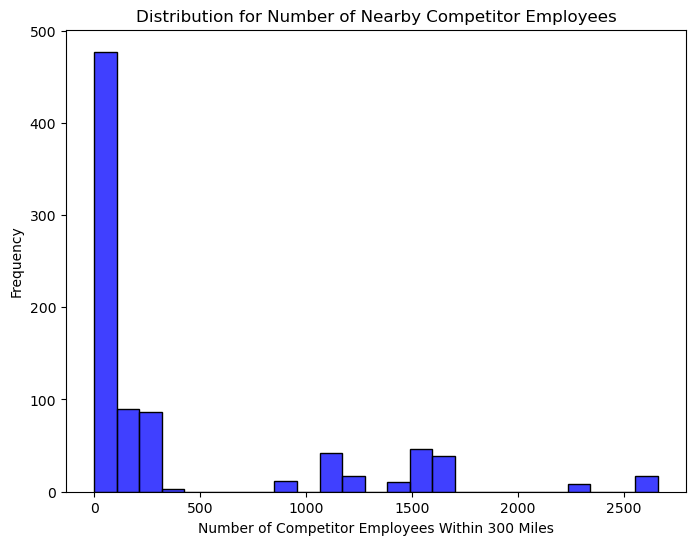

In [109]:
plt.figure(figsize=(8, 6))
sns.histplot(startups_and_salaries['competitors'], bins=25, kde=False, color='blue')

plt.title("Distribution for Number of Nearby Competitor Employees")
plt.xlabel("Number of Competitor Employees Within 300 Miles")
plt.ylabel("Frequency")
plt.show()

From this distribution of competitor employee count, it's immediately clear that a lot of workers do not have many competitor employees near them. There is a significant number who have less than 100.

There are also clusters around 1300 and 2300 competitor employees due to small samples of nearby firms with many employees being competitors for each other.

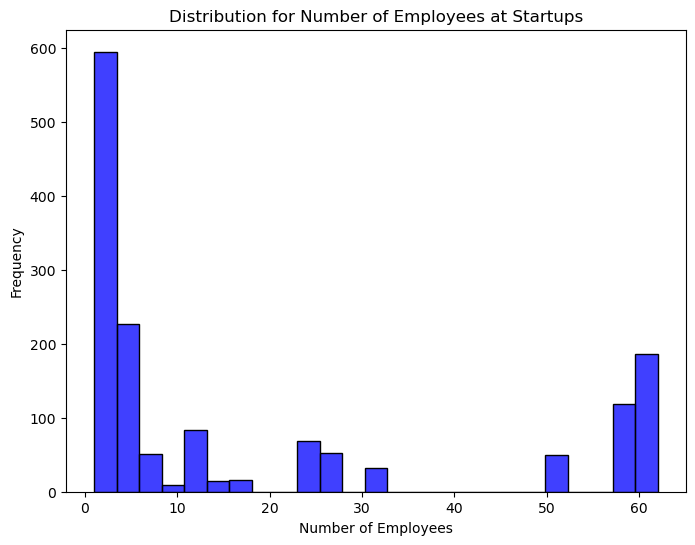

In [111]:
plt.figure(figsize=(8, 6))
sns.histplot(startups_and_salaries['num_employees'].dropna(), bins=25, color='blue')
plt.title("Distribution for Number of Employees at Startups")
plt.xlabel("Number of Employees")
plt.ylabel("Frequency")
plt.show()

Verifying this by directly plotting the distribution of the number of employees at each startup, the assumption proves correct. There is a relatively small number of startups who have roughly 50-60 employees in the data. This is considerably more than average.

Again, we see that many startups have only a few employees within our data.

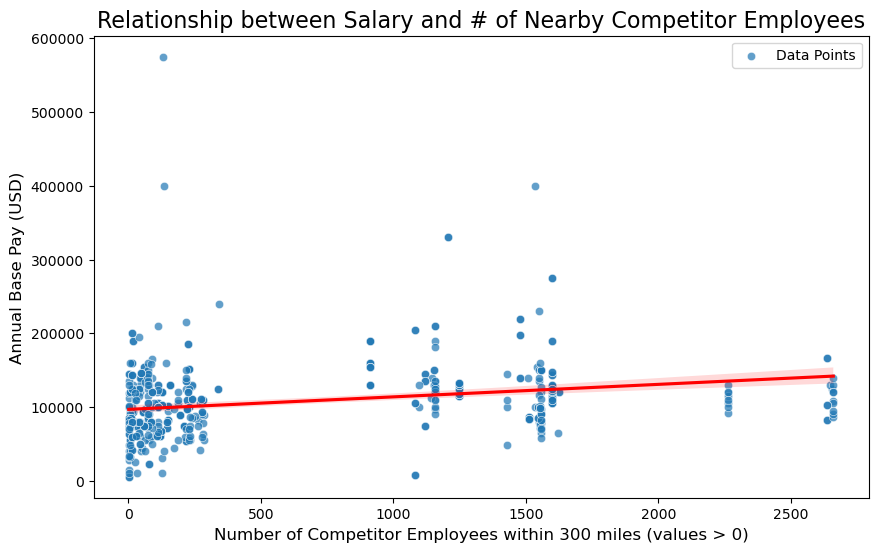

In [113]:
filtered = startups_and_salaries[startups_and_salaries['competitors'] > 0]

plt.figure(figsize=(10, 6))

sns.scatterplot(data=filtered, x='competitors', y='annual_base_pay', alpha=0.7, label="Data Points")

sns.regplot(data=filtered, x='competitors', y='annual_base_pay', scatter=False,
            color='red', label="Line of Best Fit")

plt.title('Relationship between Salary and # of Nearby Competitor Employees', fontsize=16)
plt.xlabel('Number of Competitor Employees within 300 miles (values > 0)', fontsize=12)
plt.ylabel('Annual Base Pay (USD)', fontsize=12)

plt.savefig("salary_vs_competitors.png", dpi=300, bbox_inches="tight")
plt.show()

Now creating a scatter plot, the same clusters appear, as expected. 

There is a severely weak positive relationship between the number of nearby competitor employees and salary based on the available data. Salary and location changes over time would have more potential to capture the effect. 

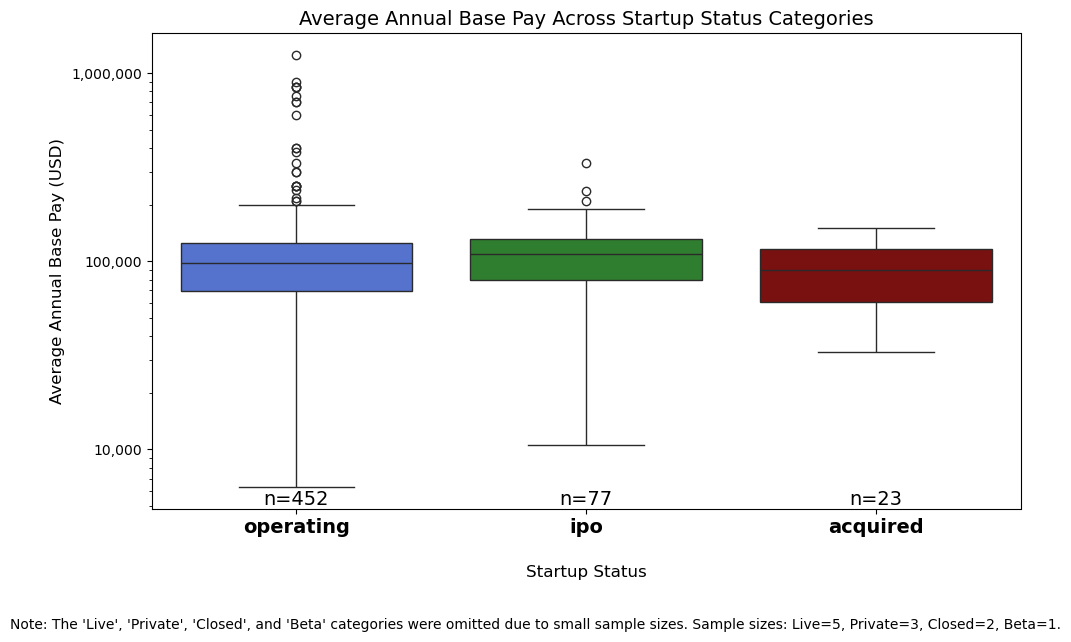

In [115]:

# Filtering startup status
filtered = startups_and_salaries[startups_and_salaries['status'].isin(['operating', 'ipo', 'acquired'])]

# Calculating average pay
startup_avg_pay = filtered.groupby(['startup_id', 'status'])['annual_base_pay'].mean().reset_index()

status_counts = startup_avg_pay['status'].value_counts()

# Making sample size table
sample_size_table = pd.DataFrame(status_counts).reset_index()
sample_size_table.columns = ['Status', 'Sample Size']

custom_palette = {'operating': 'royalblue', 'ipo': 'forestgreen', 'acquired': 'darkred'}

plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    x='status', y='annual_base_pay', data=startup_avg_pay, 
    order=status_counts.index, palette=custom_palette, hue='status'
)
plt.title("Average Annual Base Pay Across Startup Status Categories", fontsize=14)
plt.yscale("log")  # Log scale for salary distribution

# Formatting y-axis to avoid scientific notation
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Adding the sample size labels
for i, status in enumerate(status_counts.index):
    count = status_counts[status]
    plt.text(i, ax.get_ylim()[0], f'n={count}', ha='center', va='bottom', fontsize=14, color='black')

plt.figtext(
    0.5, -0.05, 
    "Note: The 'Live', 'Private', 'Closed', and 'Beta' categories were omitted due to small sample sizes. "
    "Sample sizes: Live=5, Private=3, Closed=2, Beta=1.", 
    ha='center', va='center', fontsize=10, color='black'
)

plt.xticks(fontsize=14, fontweight='bold')
plt.xlabel("Startup Status", fontsize=12, labelpad=20)
plt.ylabel("Average Annual Base Pay (USD)", fontsize=12)

plt.tight_layout()
plt.savefig("boxplot.png", dpi=300, bbox_inches="tight")
plt.show()


We now examine whether startup status matters.

It is unsurprising that IPO startups pay more than those at operating status, given that IPO is a later stage.

Acquired startups pay the least out of the three groups, although slightly. Struggling startups are unlikely to pay high wages. When they end up getting acquired, employee wages may remain low. Alternatively, some acquired startups were doing well, but got acquired by large firms due to financial incentives. This situation could lead to lower or higher wages depending on the pay structure of the acquiring firm.

Importantly, the lack of observations for the 4 remaining categories introduces potential for bias in this analysis. We merged with salary data, which is likely to include more entries for established startups.

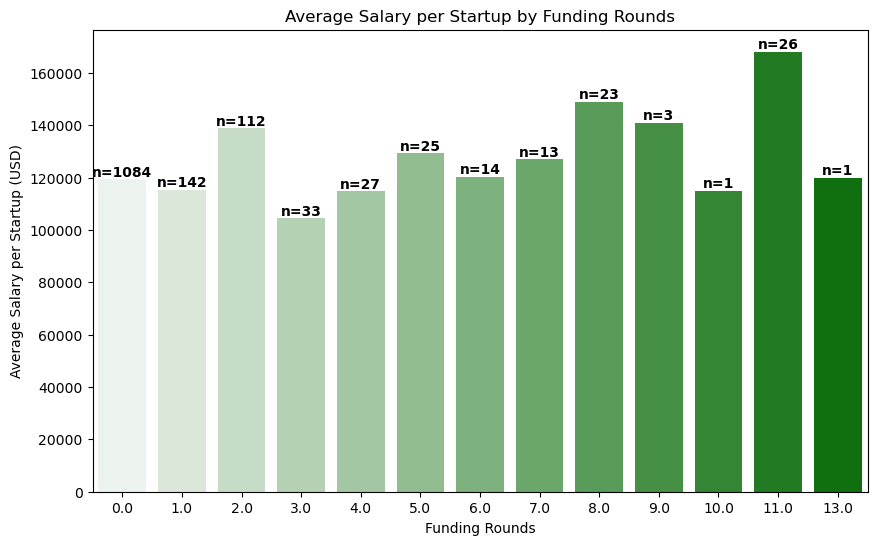

In [117]:
funding_rounds_summary = startups_and_salaries.groupby('funding_rounds').agg(
    avg_salary=('avg_salary_per_startup', 'mean'),
    count=('avg_salary_per_startup', 'count')
).reset_index()


green_palette = sns.light_palette("green", n_colors=len(funding_rounds_summary))


plt.figure(figsize=(10, 6))
ax = sns.barplot(x='funding_rounds', y='avg_salary', data=funding_rounds_summary, 
                 hue='funding_rounds', palette=green_palette, legend=False)


for i, row in funding_rounds_summary.iterrows():
    ax.text(i, row.avg_salary, f"n={int(row['count'])}", ha='center', va='bottom', 
            fontsize=10, fontweight='bold')


plt.title('Average Salary per Startup by Funding Rounds')
plt.xlabel('Funding Rounds')
plt.ylabel('Average Salary per Startup (USD)')

plt.show()

After investigating the role of funding rounds, it is clear that the average salary paid is uncorrelated with the number of rounds completed. This suggests that the money raised is possibly utilized for other purposes.
It is notable that a lot more startups have only 0, 1, or 2 funding rounds. There is an overwhelming amount of 0 funding round startups especially, indicative of either a lot of struggling startups in the data or potential data entry errors.

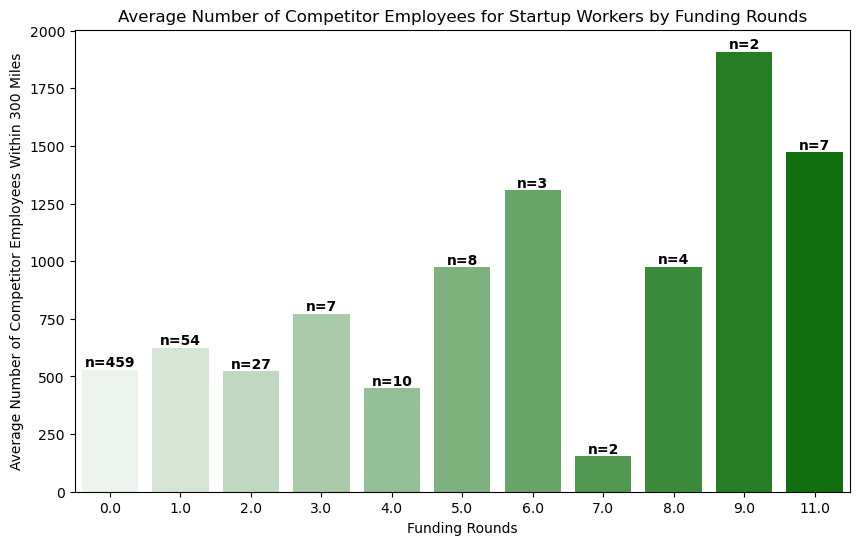

In [119]:
# calculate mean number of competitors and sample size for each funding round
funding_rounds_summary = startups_and_salaries.groupby('funding_rounds').agg(
    avg_competitors=('competitors', 'mean'),
    count=('competitors', 'count')
).reset_index()


funding_rounds_summary = funding_rounds_summary.replace([np.inf, -np.inf], np.nan).dropna()


green_palette = sns.light_palette("green", n_colors=len(funding_rounds_summary))


plt.figure(figsize=(10, 6))
ax = sns.barplot(x='funding_rounds', y='avg_competitors', data=funding_rounds_summary, 
                 hue='funding_rounds', palette=green_palette, legend=False)


x_ticks = ax.get_xticks()
for pos, (x, row) in enumerate(zip(x_ticks, funding_rounds_summary.itertuples())):
    if np.isfinite(row.avg_competitors):
        ax.text(x, row.avg_competitors, f"n={int(row.count)}", ha='center', va='bottom', 
                fontsize=10, fontweight='bold')


plt.title('Average Number of Competitor Employees for Startup Workers by Funding Rounds')
plt.xlabel('Funding Rounds')
plt.ylabel('Average Number of Competitor Employees Within 300 Miles')

plt.show()

Still, there appears to be a positive relationship between the number of funding rounds completed and the average number of competitor employees for each startup's workers. This is further evidence of several large competitor firms being located near each other. The high bars at funding rounds 9 and 11 imply that a small subset of 9 firms has accumulated a lot of capital from investors.

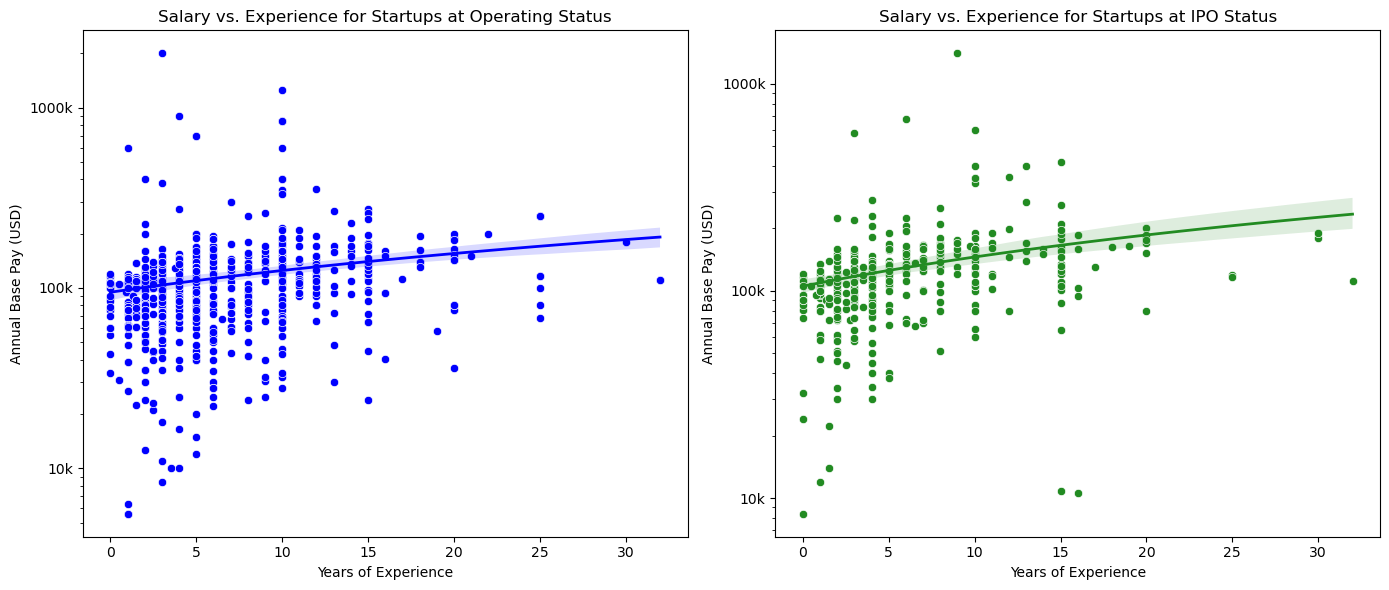

In [121]:

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

formatter = mtick.FuncFormatter(lambda x, _: f'{x/1000:.0f}k')

sns.scatterplot(x='total_experience_years', y='annual_base_pay', 
                data=startups_and_salaries[startups_and_salaries['status'] == 'operating'], 
                ax=axes[0], color='blue')
sns.regplot(x='total_experience_years', y='annual_base_pay', 
            data=startups_and_salaries[startups_and_salaries['status'] == 'operating'], 
            ax=axes[0], scatter=False, color='blue', line_kws={'linewidth': 2})
axes[0].set_title('Salary vs. Experience for Startups at Operating Status')
axes[0].set_xlabel('Years of Experience')
axes[0].set_ylabel('Annual Base Pay (USD)')
axes[0].set_yscale('log')  # log scale for salaries
axes[0].yaxis.set_major_formatter(formatter)

sns.scatterplot(x='total_experience_years', y='annual_base_pay', 
                data=startups_and_salaries[startups_and_salaries['status'] == 'ipo'], 
                ax=axes[1], color='forestgreen')
sns.regplot(x='total_experience_years', y='annual_base_pay', 
            data=startups_and_salaries[startups_and_salaries['status'] == 'ipo'], 
            ax=axes[1], scatter=False, color='forestgreen', line_kws={'linewidth': 2})
axes[1].set_title('Salary vs. Experience for Startups at IPO Status')
axes[1].set_xlabel('Years of Experience')
axes[1].set_ylabel('Annual Base Pay (USD)')
axes[1].set_yscale('log')  # log scale for salaries
axes[1].yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig("exp_prem_scatter.png", dpi=300, bbox_inches="tight")
plt.show()


Lastly, we consider Daniel Kim's findings that early stage VC-backed startups hire higher quality employees compared to established firms, giving the appearance of a startup wage premium (Kim, 2018).

If we use years of experience as a measure of quality, we notice that there's a weak positive relationship for both operating and IPO startups. This is likely due to limited sample size and not separating observations by industry. 

The effect is roughly the same across both operating and IPO startups, so earlier stage operating firms do not appear to value experience more.

# PROJECT TWO

## THE MESSAGE

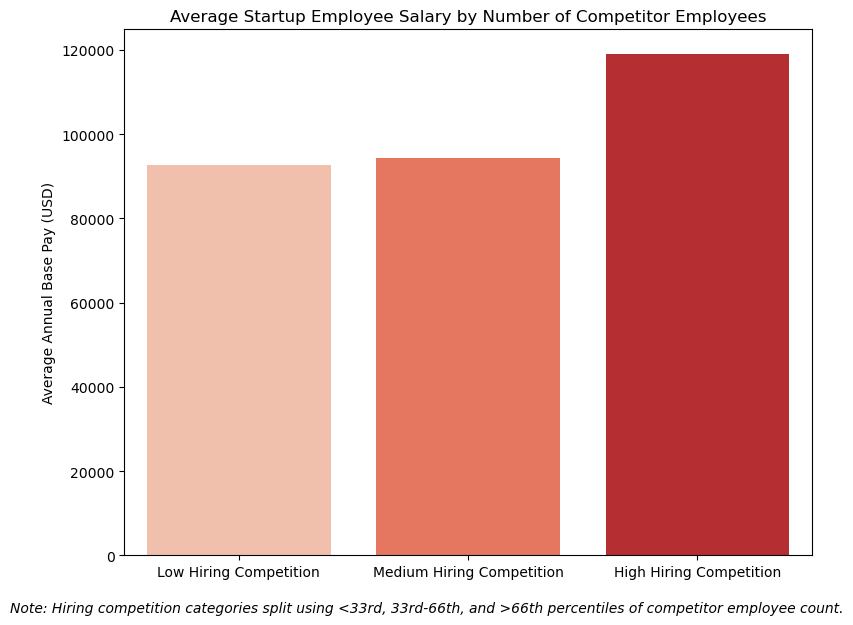

In [125]:
startups_and_salaries_clean = startups_and_salaries.dropna(subset=['competitors'])
df = startups_and_salaries_clean.copy()

# defining hiring competition levels
comp_quartiles = np.percentile(df['competitors'], [33, 66])

df = df.assign(
    comp_category=pd.cut(
        df['competitors'], 
        bins=[-np.inf, comp_quartiles[0], comp_quartiles[1], np.inf],
        labels=['Low Hiring Competition', 'Medium Hiring Competition', 'High Hiring Competition']
    ).astype('category')
)

# calculating average salary for each competition category
salary_by_comp = df.groupby('comp_category', observed=False)['annual_base_pay'].mean().reset_index()


plt.figure(figsize=(8, 6))
sns.barplot(data=salary_by_comp, x='comp_category', y='annual_base_pay',
            palette='Reds', hue ='comp_category', legend=False)


plt.title('Average Startup Employee Salary by Number of Competitor Employees')
plt.xlabel('')
plt.ylabel('Average Annual Base Pay (USD)')

# adding a note for percentiles in the plot
plt.figtext(0.5, -0.03, 'Note: Hiring competition categories split using <33rd, 33rd-66th, and >66th percentiles of competitor employee count.', 
            ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.savefig("bar.png", dpi=300, bbox_inches="tight")
plt.show()

In [126]:
print(len(startups_and_salaries_clean))

847


Although there wasn't a strong relationship between the number of competitor employees and wages, we do see differences between the categories of low, medium, and high numbers of competitor employees. Low and medium hiring competition startups pay similar salaries around 90,000 dollars, while high hiring competition startups pay roughly 30,000 dollars more annually on average at $120,000.

## MAPS

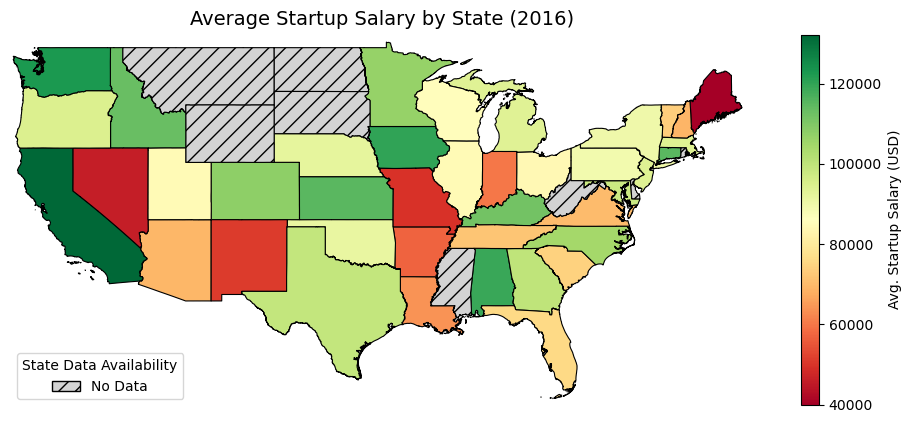

In [129]:
startups_and_salaries["Coordinates"] = startups_and_salaries.apply(
    lambda row: Point(row.location_longitude, row.location_latitude), axis=1
)
geo_s_and_s = gpd.GeoDataFrame(startups_and_salaries, geometry="Coordinates", crs="EPSG:4326")


shapefile_path = "/Users/annamezhlauk/Desktop/cb_2016_us_state_500k/cb_2016_us_state_500k.shp"
gdf_states = gpd.read_file(shapefile_path).to_crs(epsg=4326)


geo_s_and_s = gpd.sjoin(geo_s_and_s, gdf_states, how="left", predicate="within")


geo_s_and_s = geo_s_and_s.drop(columns=["index_right"], errors="ignore")


state_salary = geo_s_and_s.groupby("STUSPS").agg(
    avg_salary=("annual_base_pay", "mean")
).reset_index()


merged_gdf = gdf_states.merge(state_salary, on="STUSPS", how="left")


fig, ax = plt.subplots(1, 1, figsize=(12, 8))


merged_gdf.plot(column="avg_salary", cmap="RdYlGn", linewidth=0.8, edgecolor="black",
                legend=True, legend_kwds={"label": "Avg. Startup Salary (USD)", "shrink": 0.6}, ax=ax,
                missing_kwds={"color": "lightgray", "edgecolor": "black", "hatch": "//"})


missing_patch = mpatches.Patch(facecolor="lightgray", edgecolor="black", hatch="//", label="No Data")
plt.legend(handles=[missing_patch], loc="lower left", title="State Data Availability", fontsize=10)


ax.set_xlim(-125, -66)
ax.set_ylim(24, 50)


ax.set_title("Average Startup Salary by State (2016)", fontsize=14)
plt.axis("off")


plt.show()

California and Washington have high startup employee salaries, as expected. Notably, California underwent significant changes to its startup equity regulations in 2012. These changes allowed for more flexibility in the stock-based compensation offered to employees in response to federal regulations mandating that companies exceeding a certain amount of shareholders obey public company reporting requirements. These adjustments helped California remain a welcoming environment for developing tech firms during this time (Aran, 2017).

Surprisingly, Texas, New York, and Massachusetts are paying relatively low wages. This could be an indication of outliers in those states or a limited sample size in the high paying states that biases their salary averages up.

Overall, there seem to be gaps in the data.

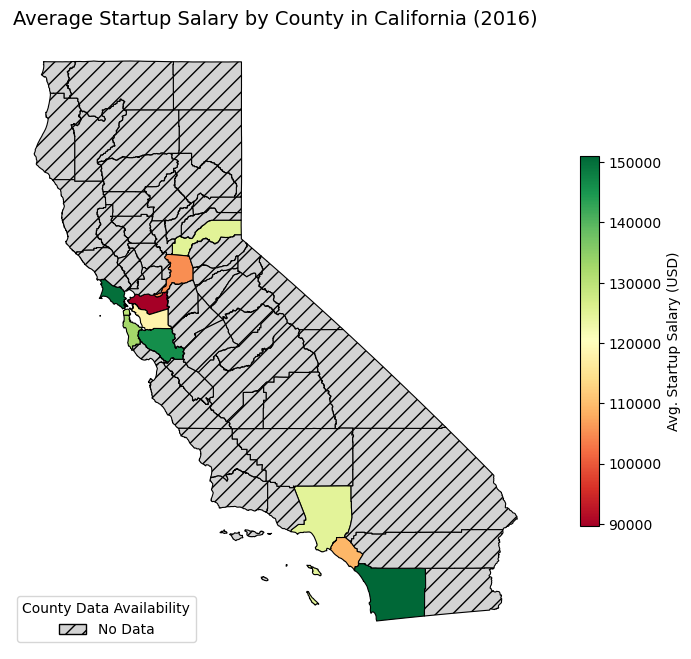

In [131]:
geo_s_and_s = gpd.GeoDataFrame(startups_and_salaries, geometry="Coordinates", crs="EPSG:4326")


shapefile_path = "/Users/annamezhlauk/Desktop/cb_2016_us_county_500k/cb_2016_us_county_500k.shp"
gdf_counties = gpd.read_file(shapefile_path).to_crs(epsg=4326)


gdf_california = gdf_counties[gdf_counties["STATEFP"] == "06"]


geo_s_and_s = gpd.sjoin(geo_s_and_s, gdf_california, how="left", predicate="within")


geo_s_and_s = geo_s_and_s.drop(columns=["index_right"], errors="ignore")


county_salary = geo_s_and_s.groupby("NAME").agg(
    avg_salary=("annual_base_pay", "mean")
).reset_index()


merged_gdf = gdf_california.merge(county_salary, on="NAME", how="left")


fig, ax = plt.subplots(1, 1, figsize=(10, 8))


merged_gdf.plot(column="avg_salary", cmap="RdYlGn", linewidth=0.8, edgecolor="black",
                legend=True, legend_kwds={"label": "Avg. Startup Salary (USD)",
                                          "shrink": 0.6}, ax=ax,
                missing_kwds={"color": "lightgray", "edgecolor": "black", "hatch": "//"})


missing_patch = mpatches.Patch(facecolor="lightgray", edgecolor="black", hatch="//", label="No Data")
plt.legend(handles=[missing_patch], loc="lower left", title="County Data Availability", fontsize=10)


ax.set_title("Average Startup Salary by County in California (2016)", fontsize=14)
plt.axis("off")


plt.show()

Zooming in on California, the highest paying state, we see an interesting range in estimates. 

Based on an article in Urban Geography, wages are somewhat lower in San Francisco than surrounding counties. Uber, Airbnb, and other firms contributing to the "freelance economy" are believed to be driving down wages in the city. This process can prevent market inefficiencies, but can also cause increased potential for income inequality and job instability. Employee bargaining power falls under these circumstances (McNeill, 2016).

It is surprising that Contra Costa county has the lowest wages. However, it's important to note that we are missing data from some of the poorest counties. Our estimates are not representative.

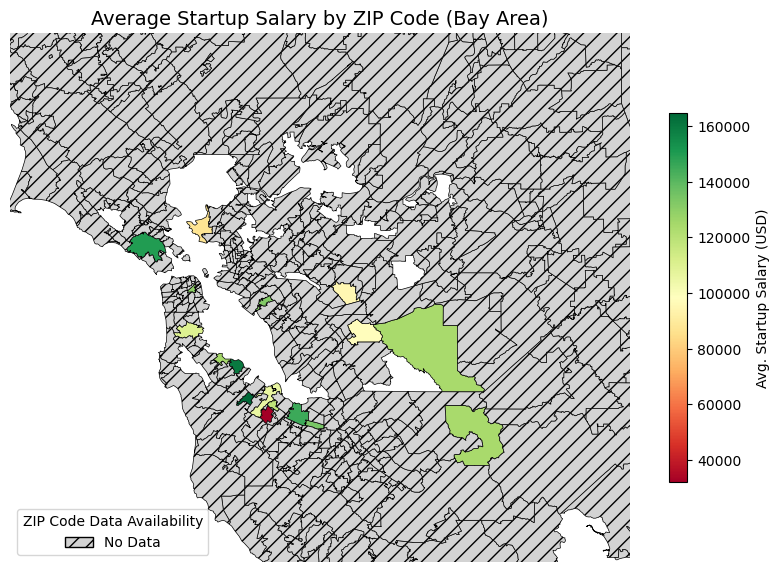

In [133]:
startups_and_salaries["Coordinates"] = startups_and_salaries.apply(
    lambda row: Point(row.location_longitude, row.location_latitude), axis=1
)
geo_s_and_s = gpd.GeoDataFrame(startups_and_salaries, geometry="Coordinates", crs="EPSG:4326")


shapefile_path = "/Users/annamezhlauk/Desktop/cb_2016_us_zcta510_500k/cb_2016_us_zcta510_500k.shp"
gdf_zctas = gpd.read_file(shapefile_path).to_crs(epsg=4326)


zip_column = "ZCTA5CE10"
gdf_zctas[zip_column] = gdf_zctas[zip_column].astype(str)


geo_s_and_s = gpd.sjoin(geo_s_and_s, gdf_zctas, how="left", predicate="within")


geo_s_and_s = geo_s_and_s.drop(columns=["index_right"], errors="ignore")

geo_s_and_s = geo_s_and_s.dropna(subset=[zip_column])

# filtering for Bay Area ZIP codes
bay_area_salaries = geo_s_and_s[geo_s_and_s[zip_column].str.startswith("94")]

# aggregate salaries by ZIP code
bay_area_salary = bay_area_salaries.groupby(zip_column).agg(avg_salary=("annual_base_pay", "mean")).reset_index()


bay_area_gdf = gdf_zctas.merge(bay_area_salary, on=zip_column, how="left")


def plot_salary_map(merged_gdf, title, xlim=None, ylim=None):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    merged_gdf.plot(column="avg_salary", cmap="RdYlGn", linewidth=0.5, edgecolor="black",
                    legend=True, legend_kwds={"label": "Avg. Startup Salary (USD)", "shrink": 0.6}, ax=ax,
                    missing_kwds={"color": "lightgray", "edgecolor": "black", "hatch": "//"})

    missing_patch = mpatches.Patch(facecolor="lightgray", edgecolor="black", hatch="//", label="No Data")
    plt.legend(handles=[missing_patch], loc="lower left", title="ZIP Code Data Availability", fontsize=10)

    ax.set_title(title, fontsize=14)
    

    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    plt.axis("off")
    plt.show()


bay_area_xlim = (-123, -121)  # longitude range for Bay Area
bay_area_ylim = (37, 38.5)    # latitude range for Bay Area

plot_salary_map(bay_area_gdf, "Average Startup Salary by ZIP Code (Bay Area)", bay_area_xlim, bay_area_ylim)

Zooming in further, we see that our previous county estimates were generated from a very limited number of zipcodes. We have salaries from just one zipcode in San Francisco county.

Out of 84 total salary observations in the Bay Area, 26 of them are in that one San Francisco zipcode.

We see a lot more zipcodes represented from the Peninsula area under San Francisco, and these areas mostly have high wages.

The lowest Bay Area wage averages are in a few zipcodes near the East Bay.

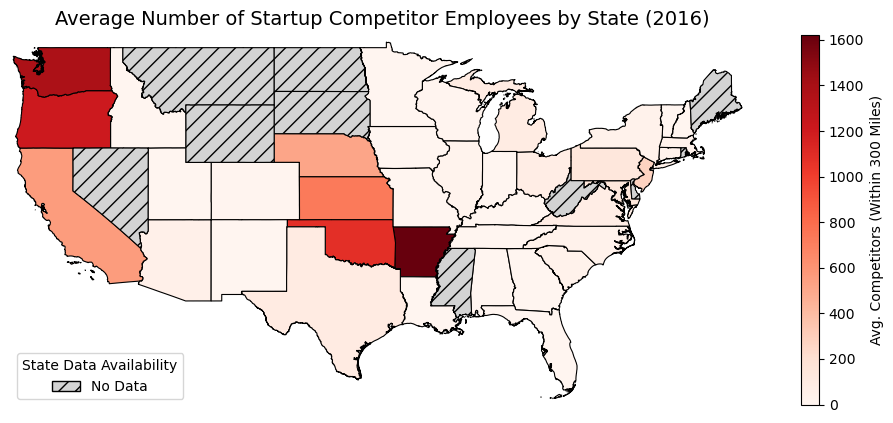

In [135]:
geo_s_and_s = gpd.GeoDataFrame(startups_and_salaries, geometry="Coordinates", crs="EPSG:4326")


shapefile_path = "/Users/annamezhlauk/Desktop/cb_2016_us_state_500k/cb_2016_us_state_500k.shp"
gdf_states = gpd.read_file(shapefile_path).to_crs(epsg=4326)


geo_s_and_s = gpd.sjoin(geo_s_and_s, gdf_states, how="left", predicate="within")


geo_s_and_s = geo_s_and_s.drop(columns=["index_right"], errors="ignore")


state_competitors = geo_s_and_s.groupby("STUSPS").agg(
    avg_competitors=("competitors", "mean")
).reset_index()


merged_gdf = gdf_states.merge(state_competitors, on="STUSPS", how="left")


fig, ax = plt.subplots(1, 1, figsize=(12, 8))


merged_gdf.plot(column="avg_competitors", cmap="Reds", linewidth=0.8, edgecolor="black",
                legend=True, legend_kwds={"label": "Avg. Competitors (Within 300 Miles)",
                                          "shrink": 0.6}, ax=ax,
                missing_kwds={"color": "lightgray", "edgecolor": "black", "hatch": "//"})


missing_patch = mpatches.Patch(facecolor="lightgray", edgecolor="black", hatch="//", label="No Data")
plt.legend(handles=[missing_patch], loc="lower left", title="State Data Availability", fontsize=10)


ax.set_xlim(-125, -66)
ax.set_ylim(24, 50)


ax.set_title("Average Number of Startup Competitor Employees by State (2016)", fontsize=14)
plt.axis("off")

states_of_interest = ["WA", "OR", "OK", "AR", "CA"]

state_competitors_filtered = state_competitors[state_competitors["STUSPS"].isin(states_of_interest)]

plt.show()

A lot of firms have very few competitor employees so it is logical that many states would have a low average number of competitors. 

Washington and Oregon firms tend to have a lot of competitor employees at roughly 1400 and 1200 employees respectively. 

It is interesting that Oklahoma and Arkansas have so many competitor employees, however, as they are not known for tech companies. Oklahoma has an average of about 1000, while the Arkansas average is over 1600!

California should in theory have a greater average number of competitor employees than just 560. However, it might be that some competitors in California are outside of the 300 mile limit and were not detected.

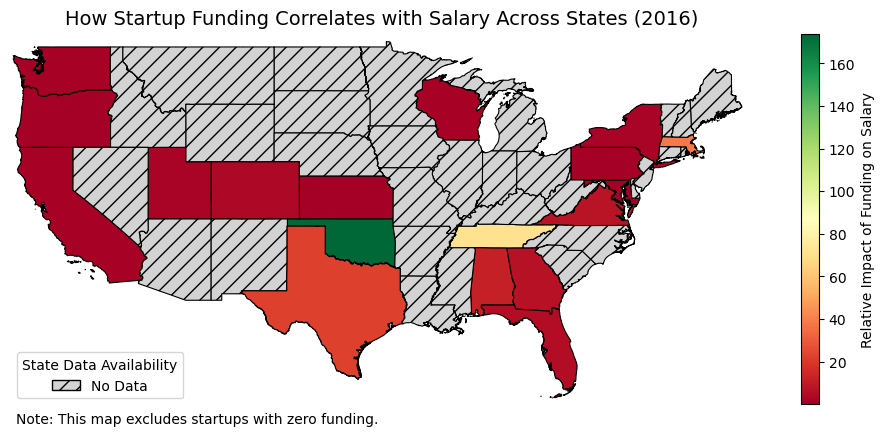

In [137]:
filtered_data = startups_and_salaries[startups_and_salaries["funding_total_usd"] > 0].copy()


filtered_data["Coordinates"] = filtered_data.apply(
    lambda row: Point(row.location_longitude, row.location_latitude), axis=1
)
geo_s_and_s = gpd.GeoDataFrame(filtered_data, geometry="Coordinates", crs="EPSG:4326")



geo_s_and_s = gpd.sjoin(geo_s_and_s, gdf_states, how="left", predicate="within")
geo_s_and_s = geo_s_and_s.drop(columns=["index_right"], errors="ignore")


state_averages = geo_s_and_s.groupby("STUSPS").agg(
    avg_salary=("annual_base_pay", "mean"),
    avg_funding=("funding_total_usd", "mean")
).reset_index()


national_avg_salary = geo_s_and_s["annual_base_pay"].mean()
national_avg_funding = geo_s_and_s["funding_total_usd"].mean()


state_averages["funding_effect"] = state_averages["avg_salary"] / state_averages["avg_funding"]


national_funding_effect = national_avg_salary / national_avg_funding


state_averages["relative_funding_effect"] = state_averages["funding_effect"] / national_funding_effect


merged_gdf = gdf_states.merge(state_averages, on="STUSPS", how="left")


fig, ax = plt.subplots(1, 1, figsize=(12, 8))


merged_gdf.plot(column="relative_funding_effect", cmap="RdYlGn", linewidth=0.8, edgecolor="black",
                legend=True, legend_kwds={"label": "Relative Impact of Funding on Salary",
                                          "shrink": 0.6}, ax=ax,
                missing_kwds={"color": "lightgray", "edgecolor": "black", "hatch": "//"})


missing_patch = mpatches.Patch(facecolor="lightgray", edgecolor="black", hatch="//", label="No Data")
plt.legend(handles=[missing_patch], loc="lower left", title="State Data Availability", fontsize=10)


ax.set_xlim(-125, -66) 
ax.set_ylim(24, 50)


ax.set_title("How Startup Funding Correlates with Salary Across States (2016)", fontsize=14)
plt.axis("off")

# note
plt.figtext(0.281, 0.24, "Note: This map excludes startups with zero funding.", ha="center",
            fontsize=10, color="black")


plt.show()

Now, we analyze the relationship between funding and salary by state. This variable is calculated by first dividing the average salary by the average funding level for all observations then computing this effect individually for each state. Lastly, each states value is divided by the overall average to get the relative impact of funding.  

Once again, Oklahoma features a surprising result. From the previous map, we know that the state tends to pay high startup employee salaries so this map suggests that it does this despite relatively low firm funding levels on average.

Startup funding seems to be uncorrelated with salary for the other states where we have data, consistent with project 1 results.

## REGRESSIONS

In [140]:
y = startups_and_salaries_clean['annual_base_pay']

# data cleaning function for regression
def clean_data(X):
    # converting to numeric & coercing errors into NaN
    X = X.apply(pd.to_numeric, errors='coerce')
    X = X.dropna()
    return X

# specification 1
X1 = startups_and_salaries_clean[['competitors']]
X1 = sm.add_constant(X1)
X1 = X1.dropna() 


# specification 2
X2 = startups_and_salaries_clean[['competitors', 'funding_rounds']]
X2 = sm.add_constant(X2)
X2 = X2.dropna()

# specification 3
status_dummies = pd.get_dummies(startups_and_salaries_clean['status'])
status_dummies = status_dummies.drop(columns=['beta'])
X3 = startups_and_salaries_clean[['competitors']].join(status_dummies)
X3 = sm.add_constant(X3) 
X3 = clean_data(X3)
X3 = X3.astype(float)
X3 = X3.apply(pd.to_numeric, errors="coerce")

# specification 4
status_dummies = pd.get_dummies(startups_and_salaries_clean['status'])
status_dummies = status_dummies.drop(columns=['beta'])
X4 = startups_and_salaries_clean[['competitors', 'funding_rounds']].join(status_dummies)
X4 = sm.add_constant(X4) 
X4 = clean_data(X4)
X4 = X4.astype(float)
X4 = X4.apply(pd.to_numeric, errors="coerce")


# specification 5
X5 = startups_and_salaries_clean[['competitors', 'total_experience_years']]
X5 = sm.add_constant(X5)
X5 = X5.dropna()

# specification 6
X6 = startups_and_salaries_clean[['competitors', 'funding_rounds', 'total_experience_years']].join(status_dummies)
X6 = sm.add_constant(X6) 
X6 = clean_data(X6)
X6 = X6.astype(float)
X6 = X6.apply(pd.to_numeric, errors="coerce")

# specification 7
X7 = startups_and_salaries_clean[['competitors', 'num_employees']]
X7 = sm.add_constant(X7)
X7 = X7.dropna()


model1 = sm.OLS(y.loc[X1.index], X1).fit()
model2 = sm.OLS(y.loc[X2.index], X2).fit()
model3 = sm.OLS(y.loc[X3.index], X3).fit()
model4 = sm.OLS(y.loc[X4.index], X4).fit()
model5 = sm.OLS(y.loc[X5.index], X5).fit()
model6 = sm.OLS(y.loc[X6.index], X6).fit()
model7 = sm.OLS(y.loc[X7.index], X7).fit()


custom_order = ["competitors", "funding_rounds", "live", "operating",
                "ipo", "acquired", "closed",
                "total_experience_years", "num_employees", "const"]
stargazer = Stargazer([model1, model2, model3, model4, model5, model6, model7])
stargazer.covariate_order(custom_order)
stargazer.title(r"""
<h3>Preferred Specification:</h3><br> 
\[
Y = \beta_0 + \beta_1 \text{competitors} + \beta_2 \text{funding\_rounds} + \beta_3 \text{live} 
+ \beta_4 \text{operating} + \beta_5 \text{ipo} + \beta_6 \text{acquired} + \beta_6 \text{closed} + \beta_7 \text{years\_of\_experience} + \epsilon
\]
""")
display(HTML(stargazer.render_html()))

From specification 1, we see that more competitor employees is associated with only slightly higher salaries. This estimate is statistically significant at a 1% level. Having 100 more competitor employees is associated with a salary roughly $1840 higher on average. 

Including funding rounds, the coefficient on competitors falls, indicating that startups with more competitors had more funding rounds. Funding rounds is interesting as a variable since it signals both how developed a startup is and how much funding may be available to spend on employee wages. 

In specification 1, too much of the variation in salary was attributed to varying numbers of competitors when funding rounds was actually explaining some of it. For each additional funding round, employee salaries were about $2550 higher on average when controlling for number of competitor employees, which is a small but notable trend.

For specification 3, we include indicator variables for startup status, but they do not contribute to the regression after controlling for the number of competitors. The standard errors for the status coefficients are large due to small sample sizes.

Interestingly, acquired status becomes statistically significant if we hold funding rounds constant. While acquired startups may pay lower wages than beta startups in general, they do pay roughly $54,000 less on average if we control for both the number of competitors and the number of funding rounds. Most startups in the data have few funding rounds so the estimate is most relevant to lower funding startups. Acquired startups that have very few funding rounds may have been acquired because they were struggling, while beta startups that have few funding rounds could just be very new.

Specification 5 shows that an extra year of experience is associated with a salary roughly $1900 higher on average controlling for competitors. The coefficient on competitors increases, indicating that firms who had higher levels of competitor employees also had less experienced employees. This result suggests that startups may prefer less experience when they are facing hiring competition. However, it could be that several big firms are simply hiring more inexperienced workers than average, inflating the regression coefficient.

Moving on to the preferred regression (specification 6), we notice that the estimate for acquired becomes smaller in magnitude after including years of experience in the regression. Acquired startups are hiring less experienced employees on average. The coefficient on years of experience also increases to over $2800, suggesting that experience has a stronger association with salary than specification 5 suggests. Startups in different stages likely have varying preferences for experience level so we observe a stronger relationship within employees at very similar startups. Startups of different status likely prioritize different factors in hiring. The estimate reflects varying incentives and business needs, making it an interesting area for further analysis.

Lastly, the coefficient on competitors decreases the most when controlling for the number of employees. Hiring 10 more employees is associated with employee wages that are about $3270 higher among firms with the same number of competitors. This means that the additional employees would be outside of a 300 mile radius of other employees, indicating a potential wage premium for firms hiring many remote workers.

In [142]:
# Clean and align the datasets
y = startups_and_salaries_clean['total_experience_years']

X1 = sm.add_constant(status_dummies)

# specification 2
startups_and_salaries_clean.loc[:, 'any_funding'] = (startups_and_salaries_clean['funding_rounds'] > 0).astype(int)
X2 = startups_and_salaries_clean[['any_funding']].join(status_dummies)
X2 = sm.add_constant(X2)

# specification 3
X3 = startups_and_salaries_clean[['funding_rounds']].join(status_dummies)
X3 = sm.add_constant(X3)

# specification 4
X4 = startups_and_salaries_clean[['num_employees']].join(status_dummies)
X4 = sm.add_constant(X4)

def clean_data(X, y):
    # Coerce non-numeric data and drop NaNs from both X and y
    X_clean = X.apply(pd.to_numeric).dropna()
    y_clean = pd.to_numeric(y).dropna()

    # Find the common index after cleaning both X and y
    common_index = X_clean.index.intersection(y_clean.index)
    X_clean = X_clean.loc[common_index]
    y_clean = y_clean.loc[common_index]
    
    return X_clean, y_clean

X1 = X1.astype(float)  # This will convert all bool to 0/1 and keep float64
X2 = X2.astype(float)
X3 = X3.astype(float)
X4 = X4.astype(float)

# Fit the models using the cleaned and aligned data
X1_clean, y_aligned = clean_data(X1, y)
model1 = sm.OLS(y_aligned, X1_clean).fit()

X2_clean, y_aligned = clean_data(X2.dropna(), y.dropna())
model2 = sm.OLS(y_aligned, X2_clean).fit()

# Clean and align all data
X3_clean, y_aligned = clean_data(X3.dropna(), y.dropna())
model3 = sm.OLS(y_aligned.dropna(), X3_clean.dropna()).fit()
X4_clean, y_aligned = clean_data(X4.dropna(), y.dropna())
model4 = sm.OLS(y_aligned.dropna(), X4_clean.dropna()).fit()

# Custom order for covariates
custom_order = ["live", "operating", "ipo", "acquired", "closed", "any_funding",
                "funding_rounds", "num_employees", "const"]

# Stargazer to display the models
stargazer = Stargazer([model1, model2, model3, model4])
stargazer.covariate_order(custom_order)

stargazer.title(r"""
<h3>Preferred Specification:</h3><br>
\[
Y = \beta_0 + \beta_1 \text{live} + \beta_2 \text{operating} + \beta_3 \text{ipo}
+ \beta_4 \text{acquired} + \beta_5 \text{closed} + \beta_6 \text{num\_employees} + \epsilon
\]
""")
display(HTML(stargazer.render_html()))


/var/folders/kf/6bt_dr354rd0c6hj67gfd08h0000gn/T/ipykernel_76281/120373127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  startups_and_salaries_clean.loc[:, 'any_funding'] = (startups_and_salaries_clean['funding_rounds'] > 0).astype(int)


In this set of regressions, we analyze years of experience. 

We confirm in specification 1 that acquired startups are hiring less experienced employees on average. Acquired startups hire employees with about 4.7 fewer years of experience on average compared to beta startups. It's not that acquired startups are paying unfairly low wages, but they are hiring inexperienced workers who are generally paid less. 

The funding indicator and funding rounds variables don't contribute to the regression. 

However, firms hiring 100 more employees have an average employee experience level that is roughly 2.3 years lower on average when comparing startups of the same status. Firms that have fewer employees tend to have very experienced ones, while firms with more employees hire less experienced workers.

# FINAL PROJECT:

## POTENTIAL DATA TO SCRAPE

To further investigate why places like Silicon Valley or Seattle may pay higher wages, it would be useful to compile data showing whether some regions support technology development or spur innovation more than others. This information would be especially insightful since we have salary observations for the technology sector specifically.

Although there are factors such as state laws which impact wage, it would be difficult to extract this data so that it is easily comparable among states.

Instead, to try to quantify encouragement of technology development, we can scrape tech conference information from the events section of predicthq.com using their API. Specifically, we can compare locations of tech conferences to locations of high-paid startup employees.

We cannot merge events to salaries directly, but we can compare averages of salaries across different states with the prevalence of tech conferences in those states. 

## POTENTIAL CHALLENGES

Scraping this tech conference data comes with some challenges. First, the PredictHQ API has a rate limit so requests must be spaced out. Because of this, I did have to restrict my date range to one month.

Fortunately, I was able to filter for technology-related conference events. However, I encountered issues gathering conference data for 2016. While PredictHQ does have over 8 years of historical data, there were no recorded technology conferences before 2021. Events in 2025 had the most extensive data availability, so I chose to scrape conferences from March of 2025. Although these events do not line up with the salary data time frame, they will still reflect investment into tech events after a potential history of high startup employee wages.

## SCRAPING DATA FROM A WEBSITE

In [150]:
access_token = '3G32GF_uTVR1gKLj3T5veLxI2EzKBN2oH-Po0bdt'

url = "https://api.predicthq.com/v1/events/"
headers = {
    "Authorization": f"Bearer {access_token}",
    "Accept": "application/json"
}

# set query parameters
params = {
    "country": "US",
    "category": "conferences",
    "q": "technology",
    "active.gte": "2025-03-01",
    "active.lte": "2025-03-31",
    "limit": 100
}


all_events = []

Here, I'm filtering for US tech conference events in March of 2025. I set a high limit parameter so I could extract more data at one time.

In [152]:
# function to fetch events with retries
def fetch_events():
    next_url = url

    while next_url:
        response = requests.get(next_url, headers=headers, params=params)
        
        if response.status_code == 200:
            data = response.json()
            all_events.extend(data['results'])

            # check for another page
            next_url = data.get("next", None)
        elif response.status_code == 429:  # rate limit exceeded
            wait_time = 2 ** (len(all_events) // 100)  # exponential backoff
            print(f"Rate limit exceeded (429). Retrying in {wait_time} seconds...")
            time.sleep(wait_time)
        elif response.status_code == 503:  # server error
            wait_time = 2 ** (len(all_events) // 100)
            print(f"503 error encountered. Retrying in {wait_time} seconds...")
            time.sleep(wait_time)
        else:
            print(f"Error: {response.status_code} - {response.text}")
            break


fetch_events()

df = pd.DataFrame(all_events)

This is a function to fetch events. It includes exponential backoff to space out requests in case the rate limit is exceeded.

## VISUALIZING THE SCRAPED DATASET

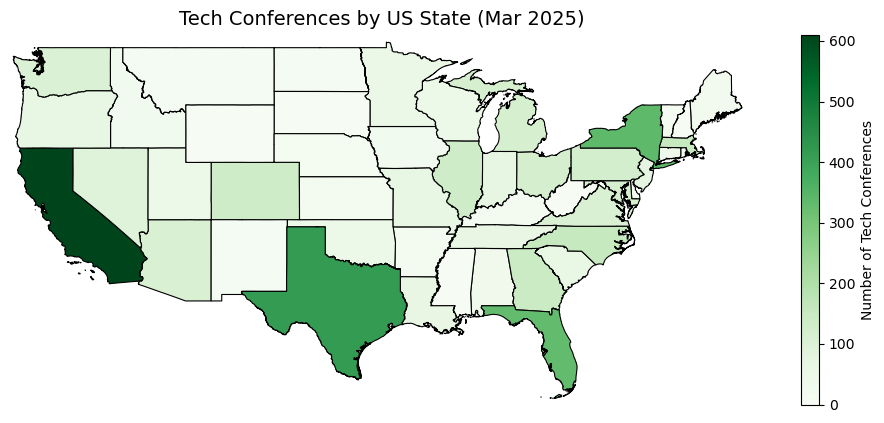

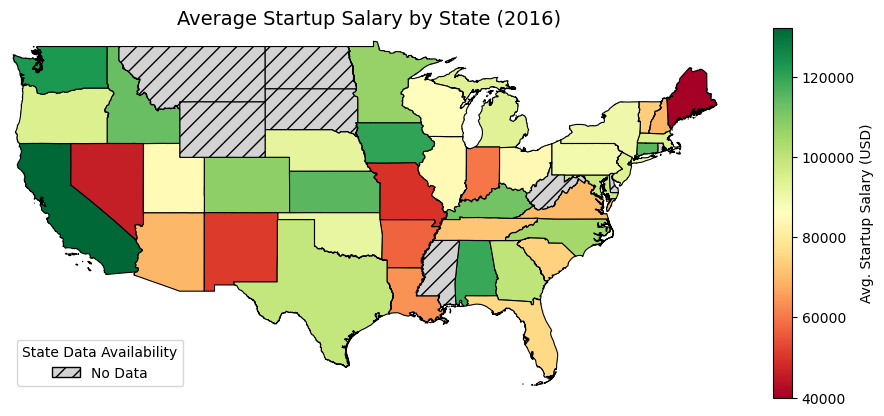

In [155]:
df['Coordinates'] = df['location'].apply(lambda x: Point(x[0], x[1]))  
geo_conf = gpd.GeoDataFrame(df, geometry="Coordinates", crs="EPSG:4326") 

# load US state shapefile 
shapefile_path = "/Users/annamezhlauk/Desktop/cb_2016_us_state_500k/cb_2016_us_state_500k.shp"
gdf_states = gpd.read_file(shapefile_path)

gdf_states = gdf_states.to_crs(epsg=4326)



# asssign states to tech conferences based on conference locations
geo_conf = gpd.sjoin(geo_conf, gdf_states, how="left", predicate="intersects")

geo_conf = geo_conf.drop(columns=["index_right"], errors="ignore")

# count number of tech conferences per state
state_conf_count = geo_conf.groupby("STUSPS").size().reset_index(name="tech_conferences")

merged_gdf = gdf_states.merge(state_conf_count, on="STUSPS", how="left")

merged_gdf["tech_conferences"] = merged_gdf["tech_conferences"].fillna(0)


fig, ax = plt.subplots(1, 1, figsize=(12, 8))

merged_gdf.plot(column="tech_conferences", cmap="Greens", linewidth=0.8, edgecolor="black",
                legend=True, legend_kwds={"label": "Number of Tech Conferences", "shrink": 0.6}, ax=ax,
                missing_kwds={"color": "lightgray", "edgecolor": "black", "hatch": "//"})


ax.set_xlim(-125, -66)  # longitude range for the US
ax.set_ylim(24, 50)  # latitude range for the US


ax.set_title("Tech Conferences by US State (Mar 2025)", fontsize=14)


plt.axis("off")

plt.savefig("map1.png", dpi=300, bbox_inches="tight")
plt.show()


startups_and_salaries["Coordinates"] = startups_and_salaries.apply(
    lambda row: Point(row.location_longitude, row.location_latitude), axis=1
)
geo_s_and_s = gpd.GeoDataFrame(startups_and_salaries, geometry="Coordinates", crs="EPSG:4326")


shapefile_path = "/Users/annamezhlauk/Desktop/cb_2016_us_state_500k/cb_2016_us_state_500k.shp"
gdf_states = gpd.read_file(shapefile_path).to_crs(epsg=4326)


geo_s_and_s = gpd.sjoin(geo_s_and_s, gdf_states, how="left", predicate="within")


geo_s_and_s = geo_s_and_s.drop(columns=["index_right"], errors="ignore")


state_salary = geo_s_and_s.groupby("STUSPS").agg(
    avg_salary=("annual_base_pay", "mean")
).reset_index()


merged_gdf = gdf_states.merge(state_salary, on="STUSPS", how="left")


fig, ax = plt.subplots(1, 1, figsize=(11.59, 8))


merged_gdf.plot(column="avg_salary", cmap="RdYlGn", linewidth=0.8, edgecolor="black",
                legend=True, legend_kwds={"label": "Avg. Startup Salary (USD)", "shrink": 0.6}, ax=ax,
                missing_kwds={"color": "lightgray", "edgecolor": "black", "hatch": "//"})


missing_patch = mpatches.Patch(facecolor="lightgray", edgecolor="black", hatch="//", label="No Data")
plt.legend(handles=[missing_patch], loc="lower left", title="State Data Availability", fontsize=10)


ax.set_xlim(-125, -66)
ax.set_ylim(24, 50)


ax.set_title("Average Startup Salary by State (2016)", fontsize=14)
plt.axis("off")

plt.savefig("map2.png", dpi=300, bbox_inches="tight")
plt.show()

Comparing with our earlier map of average state salaries, we notice that there were over 600 tech conferences in California. This is expected as the state has very high startup employee wages and is generally known as a "technology hub". Texas has many conferences as well, matching its moderately high 2016 salaries. 

Florida and New York also feature many tech conferences in March, but they had fairly average salaries. This could be an indication of technology sector development since 2016, but it is hard to say for sure. The tech conference frequency was calculated using one month of data and is not a complete measure of technology development.

Washington had fewer tech conferences than expected, but this could again be due to the limited date range.

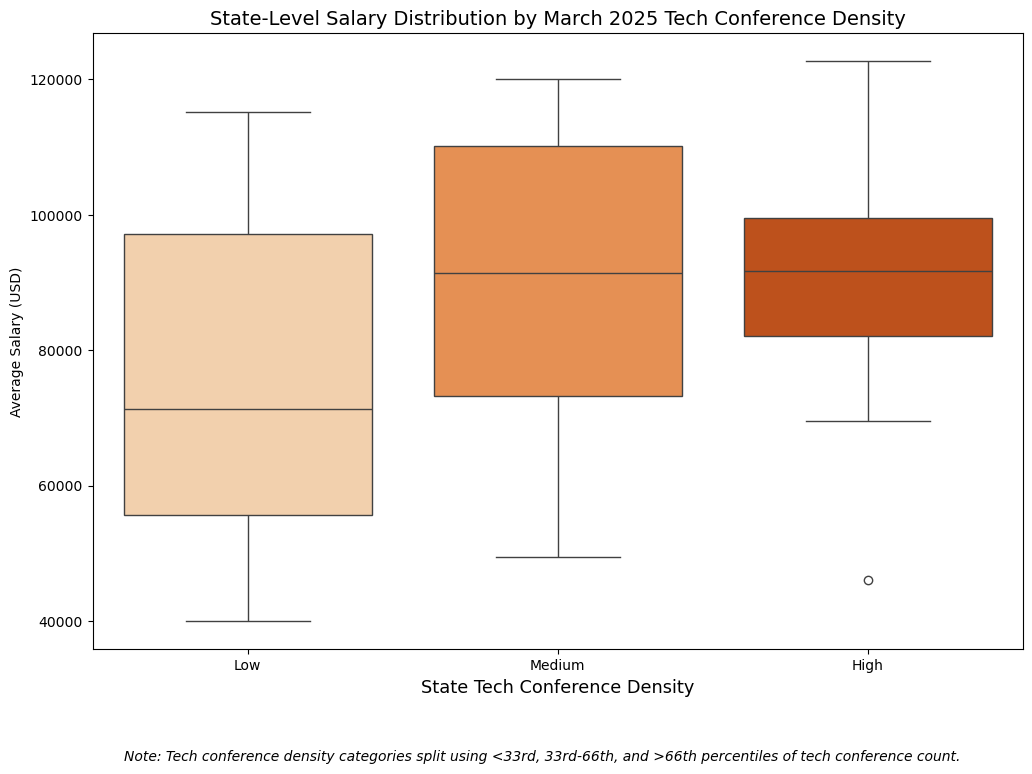

In [157]:
state_conf_count = geo_conf.groupby("STUSPS").agg(
    tech_conference_count=("id", "count")
).reset_index()

state_data = state_conf_count.merge(state_salary, on="STUSPS", how="left")

# define conference density categories
bins = [0, state_data['tech_conference_count'].quantile(0.33), 
        state_data['tech_conference_count'].quantile(0.66), 
        state_data['tech_conference_count'].max()]

labels = ['Low', 'Medium', 'High']

# categorize each state
state_data['conference_category'] = pd.cut(state_data['tech_conference_count'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(12, 8))

ax = sns.boxplot(data=state_data, x="conference_category", y="avg_salary", palette="Oranges", hue="conference_category", legend=False)


plt.title("State-Level Salary Distribution by March 2025 Tech Conference Density", fontsize=14)
plt.xlabel("State Tech Conference Density", fontsize=12.8)
plt.ylabel("Average Salary (USD)")

plt.figtext(0.5, -0.03, 'Note: Tech conference density categories split using <33rd, 33rd-66th, and >66th percentiles of tech conference count.', 
            ha='center', fontsize=10, style='italic')


plt.show()

Looking at salary distribution, there's noticeably much more spread within low density states. Their median wages are also relatively low at only 70,000 dollars. Some of these states could have fewer technology sector opportunities or demand for those positions, resulting in lower wages. Other low density states could have many opportunities, but they simply contain fewer urban areas so they do not host conferences as often.

The median salaries for medium and high tech conference density are considerably higher at about $90,000.

The spread for high density states is low, indicative of consistent high wages in those regions.

## REGRESSION TREE

In [216]:
eq1 = r"""
\min_{j,s} \left[ \sum_{i: x_{i,j} \leq s, x_i \in R1}
    (\ln(\text{salary}_i + 1) - \hat{\ln(\text{salary}_{R1} + 1)})^2 +  
    \sum_{i: x_{i,j} > s, x_i \in R2}
    (\ln(\text{salary}_i + 1) - \hat{\ln(\text{salary}_{R2} + 1)})^2 \right]
"""
plt.rcParams.update({"text.usetex": True})  # Enable LaTeX rendering

eq1 = r"""
\min_{j,s} \left[ \sum_{i: x_{i,j} \leq s, x_i \in R1}
    (\ln(\text{salary}_i + 1) - \hat{\ln(\text{salary}_{R1} + 1)})^2 +  
    \sum_{i: x_{i,j} > s, x_i \in R2}
    (\ln(\text{salary}_i + 1) - \hat{\ln(\text{salary}_{R2} + 1)})^2 \right]
"""

fig, ax = plt.subplots(figsize=(10, 2))
ax.axis("off")

# Use LaTeX for rendering
ax.text(0.5, 0.5, f"${eq1}$", fontsize=16, ha="center", va="center")

plt.savefig("equation.png", dpi=300, bbox_inches="tight")
plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x1639b3ba0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1000x200 with 1 Axes>

Regression trees are formed by iterating through each feature (j) and evaluating all possible split points (s) for values of that feature. The split points divide the range of the predictor variable (j) into 2 regions R1 and R2 so we can compare the average natural log of salary between them. The iterative process is used to minimize the mean squared error (MSE) of the natural log of salary in both R1 and R2. It searches for optimal split and feature combinations that minimize residuals. This continues until either the maximum tree depth is reached or the number of observations in a leaf (node of the tree) falls below a pre-set limit so it cannot be split further.

In [162]:
eq2 = r"""
\min_{\text{tree} \subset T} \sum (\hat{\ln(\text{salary} + 1)}-\ln(\text{salary} + 1))^2 
+ \alpha|\text{terminal nodes in tree}|
"""
display(Math(eq2))

<IPython.core.display.Math object>

After the tree is generated, it can be pruned to prevent overfitting. This is when the tree adapts to small patterns or noise in the training data so it performs poorly when evaluated using testing data. This equation minimizes the sum of squared residuals (difference between predicted logs of salaries and actual values) for trees while simultaneously penalizing tree complexity. The alpha parameter adds a cost for the number of terminal nodes so when it is high, simple trees are favored over potentially more accurate trees with many splits.

In [224]:
X = startups_and_salaries_clean[[
    'total_experience_years', 
    'status', 
    'competitors',
    'any_funding'
]]

y = startups_and_salaries_clean['annual_base_pay']

X = pd.get_dummies(X, columns=['status'], drop_first=True)


y_logged = np.log1p(y)  


X_train, X_test, y_train, y_test = train_test_split(X, y_logged, test_size=0.2, random_state=40)


reg_tree = tree.DecisionTreeRegressor(max_depth=2, random_state=4, min_samples_leaf=4)
reg_tree.fit(X_train, y_train)

y_pred_train = reg_tree.predict(X_train)
y_pred_test = reg_tree.predict(X_test)

mse_train = metrics.mean_squared_error(y_train, y_pred_train)
mse_test = metrics.mean_squared_error(y_test, y_pred_test)

plt.figure(figsize=(25, 20))
tree.plot_tree(reg_tree, feature_names=X.columns, filled=True)
plt.savefig("regtree.png", dpi=300)
plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x1639b3ba0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 2500x2000 with 1 Axes>

This regression tree includes all of the variables from the preferred specification (column 6) in table 1 but replaces the funding level variable with a funding dummy as funding level did not generate meaningful splits. My training MSE was initially much lower than my testing MSE, so I had to lower the maximum tree depth to prevent overfitting.

I added a minimum of 4 observations per leaf since my trees originally had small sample sizes in terminal nodes, devaluing their predictions. My training and testing MSE are now closer together, so the tree is more likely to generalize well.

The root node indicates a split at 126.5 competitors, meaning this is the most important initial threshold for salary prediction. Since the average number of competitor employees is higher at 390.6, competitors may have a weaker association with salary as they increase.

Workers with fewer than 126.5 competitor employees and less than 4.25 years of experience make about e^(11.012) = $60,600 on average. Workers with fewer than 126.5 competitor employees but with more experience had a higher average at 83,500 dollars. 

Workers with more competitor employees but less than 8.5 years of experience tended to make about 100,000 dollars.
Lastly, workers with more competitor employees and more experience made about 136,000 dollars on average.

The years of experience thresholds are evenly spaced away from the average of 6.7 years so this variable may have a consistent effect on wage.

Training MSE: 0.3070938667155626
Test MSE: 0.27965884855263434


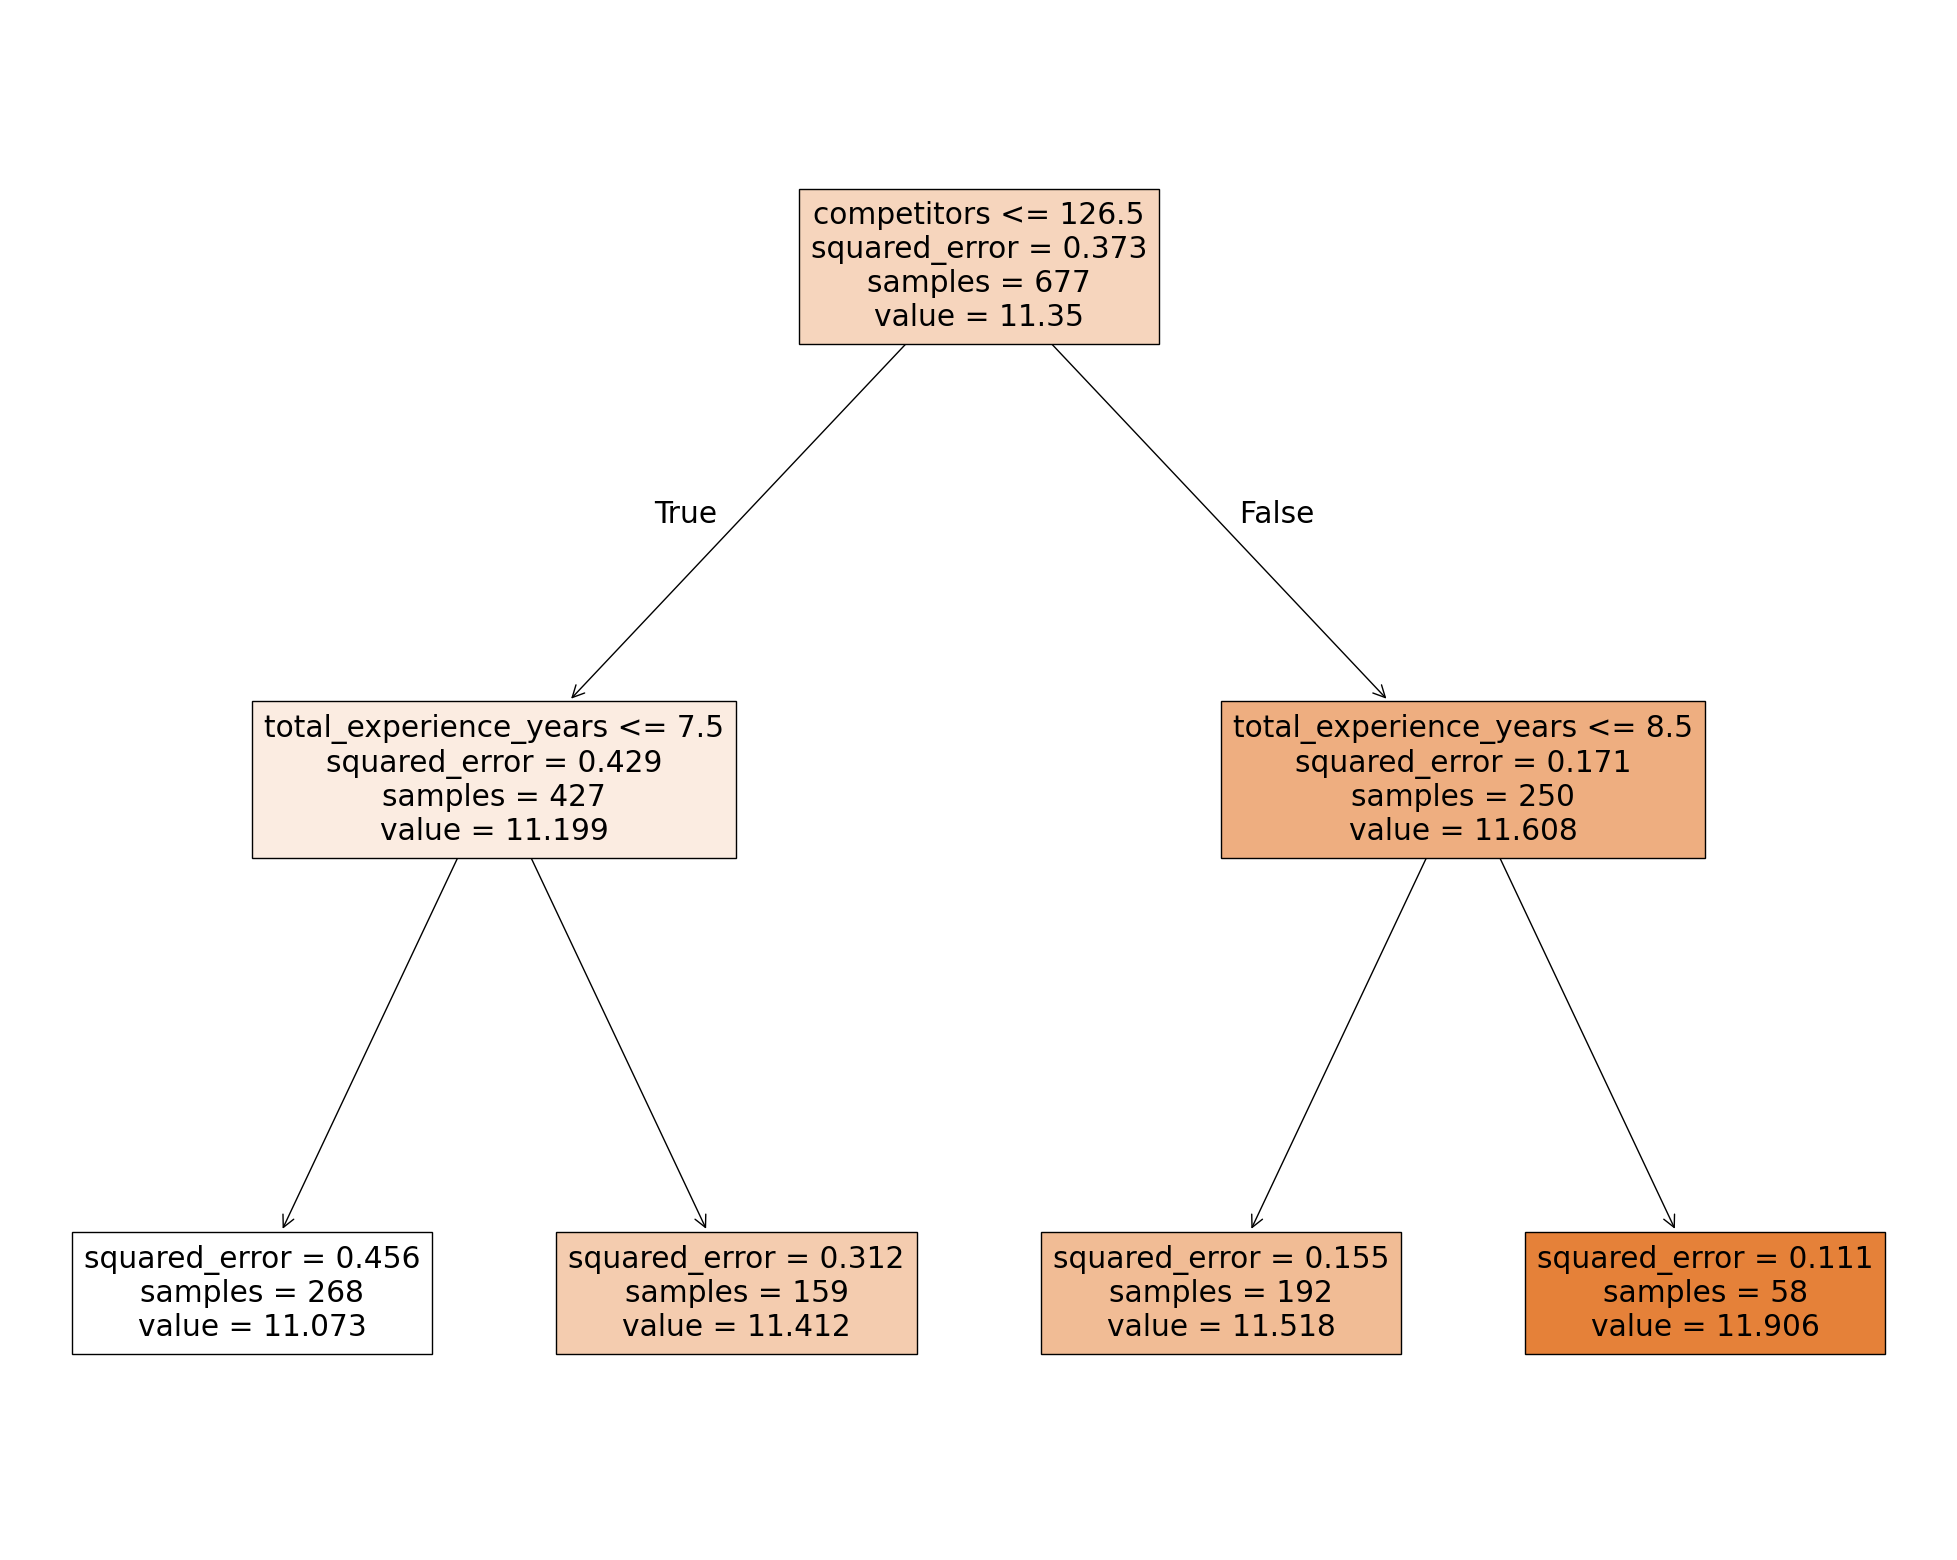

In [167]:
X = startups_and_salaries_clean[[
    'funding_total_usd', 
    'funding_rounds', 
    'status',  
    'total_experience_years', 
    'num_employees', 
    'competitors'
]]

X = pd.get_dummies(X, columns=['status'], drop_first=True)

y_logged = np.log1p(y)  

X_train, X_test, y_train, y_test = train_test_split(X, y_logged, test_size=0.2, random_state=22)

reg_tree = tree.DecisionTreeRegressor(max_depth=2, random_state=18, min_samples_leaf=10)
reg_tree.fit(X_train, y_train)

y_pred_train = reg_tree.predict(X_train)

y_pred_test = reg_tree.predict(X_test)


mse_train = metrics.mean_squared_error(y_train, y_pred_train)
mse_test = metrics.mean_squared_error(y_test, y_pred_test)
print(f"Training MSE: {mse_train}")
print(f"Test MSE: {mse_test}")


plt.figure(figsize=(25, 20))
tree.plot_tree(reg_tree, feature_names=X.columns, filled=True)
plt.show()

Now including all x variables, this tree is similar to the previous one except that the thresholds for years of experience are closer together. Both splits are high compared to the average of 6.7. 

For employees who have more than 126.5 competitor employees, the return to experience after 8.5 years is higher. However, since the sample size in terminal nodes is small, it is worth noting that this estimate could be reflecting strong experience preferences for a few high-paying firms.

Similarly to the last tree, I had to reduce maximum depth and add a minimum sample requirement for leaves.

## RANDOM FOREST

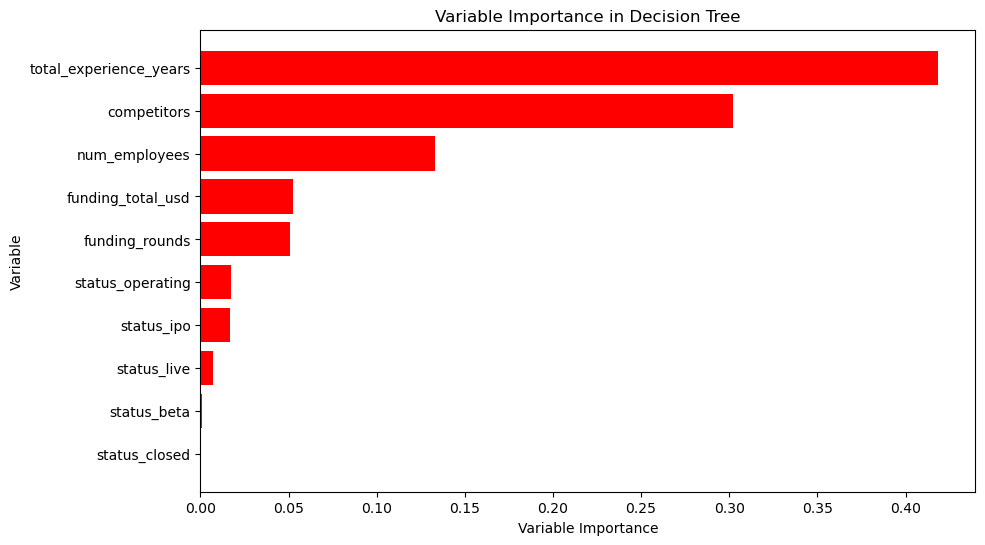

In [170]:
regr_RF = RandomForestRegressor(max_features=3, random_state=17)
regr_RF.fit(X, y)

# feature importance matrix
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': regr_RF.feature_importances_})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='r')
plt.xlabel("Variable Importance")
plt.ylabel("Variable")
plt.title("Variable Importance in Decision Tree")
plt.gca().invert_yaxis()
plt.show()

From this importance matrix, we see that years of experience is more useful for startup salary prediction. However, it wasn't the root of the regression trees. The competitor employees variables contains a more important initial split at 126.5 competitors. 

Number of employees is not a surprising third most important variable, as it can approximate firm size (and potential ability to pay higher base salaries rather than equity).

Acquired status did not contribute much to salary prediction. Although this contradicts earlier regression results, it is unsurprising given how decision trees are created. Indicator variables have much fewer values to split on, so they won't have the same predictive power as continuous variables.

## OLS VS. ML

OLS provides valuable insights when relationships are linear, quadratic, or otherwise easy to model. However, regression trees are more useful when data is clustered at different x values. It is difficult to fit a tradition model in this case. Further, the randomness component and the comparison of training MSE to test MSE help prevent overfitting more than OLS measures like adjusted R^2.

In our preferred regression (column 6 of table 1), we found that each year of experience is associated with an average salary increase of roughly $3000 holding constant startup status, funding rounds, and number of competitor employees.

From our regression tree, however, we see the exact thresholds when the relationship is most pronounced. For example, having more than 8.5 years of experience was associated with the greatest salary increase at startups facing at least moderate hiring competition. 

Despite this, regression trees are not as effective at showing the impact of indicator variables, even when they do have a strong association with the outcome. Further, regression trees do not show the impact of every x variable individually since they instead prioritize important splits.

## CONCLUSION

Merging startup data with technology sector salary data, this paper investigated the relationship between hiring competition and startup employee wage. In contrast to L. Yang's paper, I obtained a precise null effect for competition on startup employee wage after including relevant controls rather than a positive effect. This is a potential sign that my metric does not properly estimate hiring competition. However, I have provided an insightful analysis of wage determining factors nonetheless. I observed similar wage patterns in California to McNeill and Aran's articles, supporting the understanding of California as a startup haven. This idea is further validated by the high tech conference frequency I found. However, San Francisco notably stood out as an area with potential for declining wages due to advancements of a "freelance economy" (McNeill, 2016). Additionally, my regression estimates present evidence of different hiring preferences for experience level among startups of different status. Acquired startups were shown to pay less, but they also hired employees with less experience on average. The firms that hired the most employees in the data also generally had the lowest average employee experience levels. For the return to experience, OLS regression suggests it is sizable. After controlling for startup status, funding rounds, and hiring competition, each year of experience was associated with an average salary increase of about $3000. The estimated return to experience beyond 8.5 years was strongest beyond the threshold of 126.5 competitors. The number of competitors was consistently the most important initial split for predicting salaries using regression trees. While the presence of competitor employees may not explain a lot of salary variation, its threshold values and relationships with other variables have provided insight into wage setting incentives for startups of different status.

## REFERENCES

Aran, Y. (2017). Beyond Covenants Not to Compete: Equilibrium in High-Tech Startup Labor Markets. SSRN Electronic Journal, 70(4).

Brixy, U., Kohaut, S., & Schnabel, C. (2006). Do Newly Founded Firms Pay Lower Wages? First Evidence from Germany. Small Business Economics, 29(1-2), 161–171. https://doi.org/10.1007/s11187-006-0015-x

Carlsen, F., Rattsø, J., & Stokke, H. E. (2016). Education, experience, and urban wage premium. Regional Science and Urban Economics, 60, 39–49. https://doi.org/10.1016/j.regsciurbeco.2016.06.006

Hashai, N., & Markovich, S. (2017). Market Entry by High Technology Startups: The Effect of Competition Level and Startup Innovativeness. Strategy Science, 2(3), 141–160. https://doi.org/10.1287/stsc.2017.0033

Justinas Cirtautas. (2018). Startup Investments. Kaggle.com. https://www.kaggle.com/datasets/justinas/startup-investments

Kettle, S. (2017, October 5). Distance on a sphere: The Haversine Formula. Esri Community. https://community.esri.com/t5/coordinate-reference-systems-blog/distance-on-a-sphere-the-haversine-formula/ba-p/902128

Kim, D. (2016). Early Employees of Venture-Backed Startups: Selection and Wage Differentials.

Kim, J. D. (2018). Is there a startup wage premium? Evidence from MIT graduates. Research Policy, 47(3), 637–649. https://doi.org/10.1016/j.respol.2018.01.010

McNeill, D. (2016). Governing a city of unicorns: technology capital and the urban politics of San Francisco. Urban Geography, 37(4), 494–513. https://doi.org/10.1080/02723638.2016.1139868

Sorenson, O., Dahl, M. S., Canales, R., & Burton, M. D. (2021). Do Startup Employees Earn More in the Long Run? Organization Science, 32(3). https://doi.org/10.1287/orsc.2020.1371

The Devastator. (2016). Tech Salaries. Kaggle.com. https://www.kaggle.com/datasets/thedevastator/know-your-worth-tech-salaries-in-2016/data

Yang, L. (2016). Product Market Competition, Competitive Position and Employee Wage. Journal of Human Resource and Sustainability Studies, 04(03), 176–182. https://doi.org/10.4236/jhrss.2016.43019

Yankow, J. J. (2006). Why do cities pay more? An empirical examination of some competing theories of the urban wage premium. Journal of Urban Economics, 60(2), 139–161. https://doi.org/10.1016/j.jue.2006.03.004